# F20DL Lab 11

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import tensorflow as tf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

C:\Users\Louis\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the dataset into numpy arrays
X = np.load("./datasets/smiley_X_new.npy")
y = np.load("./datasets/smiley_Y_new.npy")

In [3]:
# X is a list of all images. Images are represented as columns of pixel values.
# To get pixel (r, c) of image i, use X[i][r-1][c-1][0]

# X[0] returns columns of pixel values representing the 1st image.
# X[0][2][6][0] returns the value of the pixel in the 3rd row and 7th column of the 1st image (r=3, c=7).
# y[0] returns the label for the 1st image. (0 = happy, 1 = sad)

In [4]:
# Shows smiley as an image. 'smiley' should be an element in 'X'
def show_smiley(smiley):
    plt.figure(figsize=(1,1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(smiley, cmap="Greys")

In [5]:
class_names = ["happy", "sad"]

## Convolutional Neural Networks

### CNN 0

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print("Training samples: %i, Testing samples: %i" % (X_train.shape[0], X_test.shape[0]))

Training samples: 6384, Testing samples: 2736


In [7]:
cnn0 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])
cnn0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 64)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

In [8]:
cnn0.fit(X_train, y_train, epochs=5)

Epoch 1/5
200/200 [==============================] - 1s 1ms/step - loss: 0.2929 - accuracy: 0.8596
Epoch 2/5
200/200 [==============================] - 0s 1ms/step - loss: 0.1036 - accuracy: 0.9311
Epoch 3/5
200/200 [==============================] - 0s 1ms/step - loss: 0.0975 - accuracy: 0.9342
Epoch 4/5
200/200 [==============================] - 0s 1ms/step - loss: 0.0959 - accuracy: 0.9334
Epoch 5/5
200/200 [==============================] - 0s 1ms/step - loss: 0.0947 - accuracy: 0.9326


In [9]:
test_loss, test_acc = cnn0.evaluate(X_test,  y_test, verbose=0)
print('\nTest accuracy:', test_acc)


Test accuracy: 0.9345760345458984


In [10]:
y_pred0 = cnn0.predict(X_test)

86/86 [==============================] - 0s 648us/step


Prediction:  happy


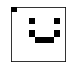

In [11]:
# Prediction for first testing image
print("Prediction: ", class_names[np.argmax(y_pred0[0])])
show_smiley(X_test[0])

In [12]:
cnn0.fit(x=X_train, y=y_train, batch_size=100, epochs=20, validation_split=0.3)

Epoch 1/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0941 - accuracy: 0.9349 - val_loss: 0.0894 - val_accuracy: 0.9363
Epoch 2/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0929 - accuracy: 0.9351 - val_loss: 0.0908 - val_accuracy: 0.9301
Epoch 3/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9355 - val_loss: 0.0901 - val_accuracy: 0.9332
Epoch 4/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0928 - accuracy: 0.9398 - val_loss: 0.0925 - val_accuracy: 0.9295
Epoch 5/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0923 - accuracy: 0.9315 - val_loss: 0.0901 - val_accuracy: 0.9363
Epoch 6/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 0.9358 - val_loss: 0.0941 - val_accuracy: 0.9295
Epoch 7/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0922 - accuracy: 0.9362 - val_loss: 0.0904 - val_accuracy: 0.9363
Epoch 8/20
45/45 [==

In [13]:
cnn0.fit(x=X_train, y=y_train, batch_size=64, epochs=20, validation_split=0.3)

Epoch 1/20
70/70 [==============================] - 0s 3ms/step - loss: 0.0930 - accuracy: 0.9331 - val_loss: 0.0924 - val_accuracy: 0.9311
Epoch 2/20
70/70 [==============================] - 0s 3ms/step - loss: 0.0928 - accuracy: 0.9355 - val_loss: 0.0913 - val_accuracy: 0.9280
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 0.0923 - accuracy: 0.9364 - val_loss: 0.0906 - val_accuracy: 0.9337
Epoch 4/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0926 - accuracy: 0.9376 - val_loss: 0.0915 - val_accuracy: 0.9285
Epoch 5/20
70/70 [==============================] - 0s 3ms/step - loss: 0.0922 - accuracy: 0.9353 - val_loss: 0.0919 - val_accuracy: 0.9280
Epoch 6/20
70/70 [==============================] - 0s 3ms/step - loss: 0.0923 - accuracy: 0.9317 - val_loss: 0.0905 - val_accuracy: 0.9348
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9349 - val_loss: 0.0907 - val_accuracy: 0.9295
Epoch 8/20
70/70 [==

In [14]:
cnn0.fit(x=X_train, y=y_train, batch_size=100, epochs=20, validation_split=0.5)

Epoch 1/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0885 - accuracy: 0.9383 - val_loss: 0.0940 - val_accuracy: 0.9326
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0883 - accuracy: 0.9380 - val_loss: 0.0943 - val_accuracy: 0.9314
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0881 - accuracy: 0.9411 - val_loss: 0.0944 - val_accuracy: 0.9308
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0884 - accuracy: 0.9389 - val_loss: 0.0944 - val_accuracy: 0.9314
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9405 - val_loss: 0.0947 - val_accuracy: 0.9295
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0882 - accuracy: 0.9433 - val_loss: 0.0951 - val_accuracy: 0.9289
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0882 - accuracy: 0.9405 - val_loss: 0.0951 - val_accuracy: 0.9289
Epoch 8/20
32/32 [==

In [15]:
cnn0.fit(x=X_train, y=y_train, batch_size=100, epochs=20, validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 0s 4ms/step - loss: 0.0914 - accuracy: 0.9354 - val_loss: 0.0943 - val_accuracy: 0.9295
Epoch 2/20
52/52 [==============================] - 0s 3ms/step - loss: 0.0912 - accuracy: 0.9350 - val_loss: 0.0936 - val_accuracy: 0.9287
Epoch 3/20
52/52 [==============================] - 0s 3ms/step - loss: 0.0906 - accuracy: 0.9393 - val_loss: 0.0934 - val_accuracy: 0.9295
Epoch 4/20
52/52 [==============================] - 0s 3ms/step - loss: 0.0907 - accuracy: 0.9385 - val_loss: 0.0927 - val_accuracy: 0.9342
Epoch 5/20
52/52 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9379 - val_loss: 0.0948 - val_accuracy: 0.9201
Epoch 6/20
52/52 [==============================] - 0s 3ms/step - loss: 0.0907 - accuracy: 0.9373 - val_loss: 0.0928 - val_accuracy: 0.9358
Epoch 7/20
52/52 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9377 - val_loss: 0.0934 - val_accuracy: 0.9272
Epoch 8/20
52/52 [==